# Model to include 

- Logistic regression 
- Naive bias  
- Random forest 
- XGboost 
- LGBM 
- CatBoost 
- Deep Neural Network (Postpone for now)



# Save the trained models 

import joblib

#### save
joblib.dump(clf, "model.pkl") 

#### load
clf2 = joblib.load("model.pkl")

clf2.predict(X[0:1])


# Separate train and test data in CSV file in data preperation folder 

# Introduction

Dataset used to make a model is found here: 

https://www.kaggle.com/kazanova/sentiment140


People has reached upto 83% accuracy here: 

https://www.kaggle.com/stoicstatic/twitter-sentiment-analysis-for-beginners

Aim for 85%+

Here is another one based on NN 

https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# import seaborn as sns 

import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, \
                        PredefinedSplit, validation_curve, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
# import seaborn as sns

In [3]:
df = pd.read_csv('Tweet_sentiment_clean.csv', encoding='ISO-8859-1')
df.sample(10)

,sentiment,text
822482,4,user amaz time sarah daniel theyr fun beauti p...
265605,0,chat best roomat ever right miss
828012,4,user ad
765591,0,anyon use adob browserlab want check say theyr...
890586,4,user know real life brian griffin joke
654965,0,user naah busi theek hain let friday night parti
1257376,4,user yep toothless manin fact pic one found on...
867457,4,quotmandatoryquot meet coupl hoursil back hat ...
350990,0,start mathshomework
308040,0,miss cuddl bear


In [4]:
df['sentiment'].value_counts()

4    799789
0    799722
Name: sentiment, dtype: int64

# Train test and validation split

-- In future need to do all the preprocessing inside the pipeline. But it is OK for now. 

#### Use customize the validation data: because the dataset is very large. 5 fold cross valdiation is not needed. Small set would do. 

In [5]:
sample_size = 10000
df1 = pd.concat([df.head(sample_size), df.tail(sample_size)])

In [13]:
X = df['text']
y = df['sentiment']

In [14]:
encoder = LabelEncoder()

# We can fit_transform entire y before train_test split.
# This is because label encoding is not feature transformation. 
y = encoder.fit_transform(y)

In [15]:
X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainvalid, y_trainvalid, test_size=0.3)

print('Train data size: \t', X_train.shape[0], 
      '\nValidation data size: \t', X_valid.shape[0], 
      '\nTest data size: \t', X_test.shape[0])

test_fold = [0 if x in X_valid.index else -1 for x in X_trainvalid.index]

ps = PredefinedSplit(test_fold)

Train data size: 	 783759 
Validation data size: 	 335898 
Test data size: 	 479854


# Hyperparameter tuning 

In [9]:
vector = TfidfVectorizer(max_features=5000)

X_train_v = vector.fit_transform(X_trainvalid)
X_test_v = vector.transform(X_test)

In [10]:
def model_plots(model, param, prange):
    
    fig = plt.figure(figsize=(12, 4))
    
    
    ax = fig.add_subplot(1, 2, 1)

    n_train, train_scores, test_scores \
        = learning_curve(model,
                         X_train_v, 
                         y_trainvalid, 
                         scoring = 'accuracy')
    
    ax.plot(n_train, np.mean(train_scores, axis=1))
    ax.plot(n_train, np.mean(test_scores, axis=1))
    plt.xlabel('Sample size')
    plt.ylabel('Accuracy')
    plt.legend(['train_set', 'test_set'])
    plt.title('Learning Curve')
    
    ax = fig.add_subplot(1, 2, 2)
    
    train_scores, test_scores \
        = validation_curve(model,
                           X_train_v,  
                           y_trainvalid, 
                           param_name=param,
                           param_range=prange, 
                           scoring = 'accuracy', 
                           cv=ps, 
                           n_jobs=-1)    

    ax.plot(prange, np.mean(train_scores, axis=1))
    ax.plot(prange, np.mean(test_scores, axis=1))
    plt.xlabel(param)
    plt.ylabel('Accuracy')
    plt.legend(['train_set', 'test_set'])
    plt.xscale('log')
    plt.title('Validation Curve')
    
    plt.show()

### Naive Bayes

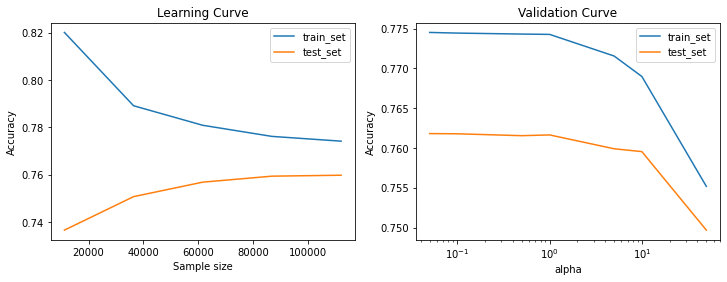

In [11]:
nb = BernoulliNB()

alphas = [0.05, 0.1, 0.5, 1, 5, 10, 50]
model_plots(nb, 'alpha', alphas)

### Logistic regression 

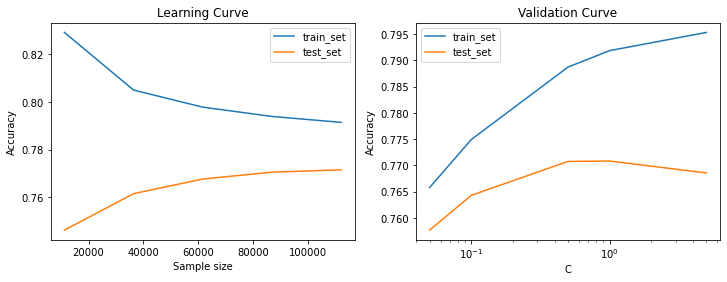

In [12]:
lr = LogisticRegression(solver='saga')

alphas = [0.05, 0.1, 0.5, 1, 5]
model_plots(lr, 'C', alphas)

In [ ]:
LogisticRegression

### Support vector machine 

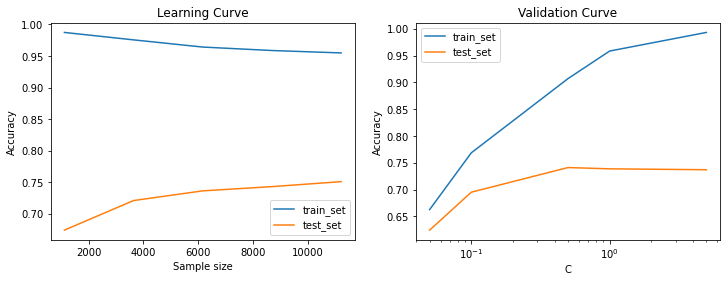

In [93]:
svc = SVC()

alphas = [0.05, 0.1, 0.5, 1, 5]
model_plots(svc, 'C', alphas)

### Random forest 

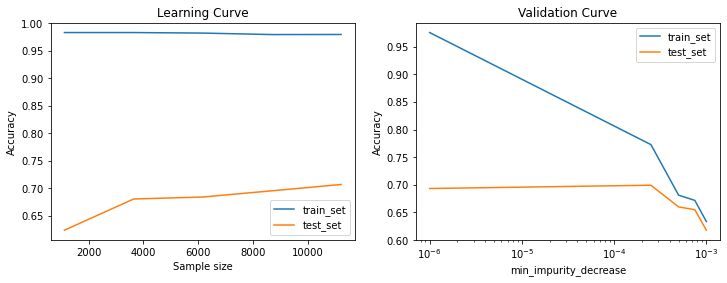

In [22]:
rf = RandomForestClassifier(n_estimators=10, 
                            max_features='sqrt',
                            n_jobs=-1)

info_gain = np.linspace(10**-6, 10**-3, 5)
model_plots(rf, 'min_impurity_decrease', info_gain)

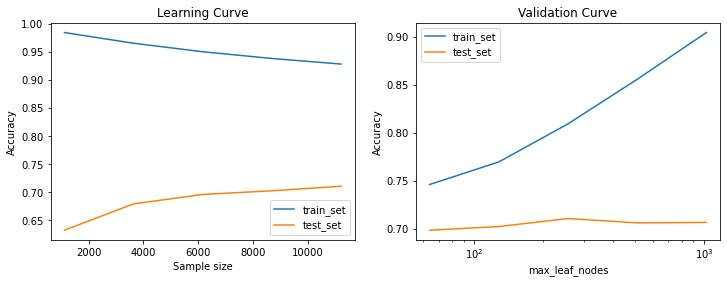

In [32]:
rf = RandomForestClassifier(n_estimators=10, 
                            max_features='sqrt',
                            min_impurity_decrease=0.00001,
                            n_jobs=-1)

n_leaf = [64, 128, 256, 512, 1024]
model_plots(rf, 'max_leaf_nodes', n_leaf)

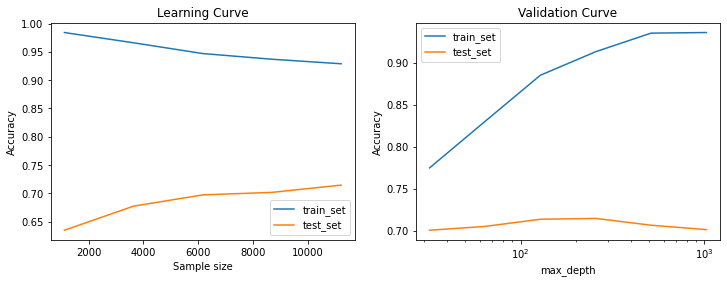

In [56]:
tree_depth = [32, 64, 128, 256, 512, 1024]
model_plots(rf, 'max_depth', tree_depth)

### XGboost 

In [13]:
xgb = XGBClassifier(n_estimators=100, 
                    learning_rate=0.001,
                    gamma=0.0001,
                    n_jobs=-1,
                    eval_set=ps, 
                    early_stopping_rounds=[5])

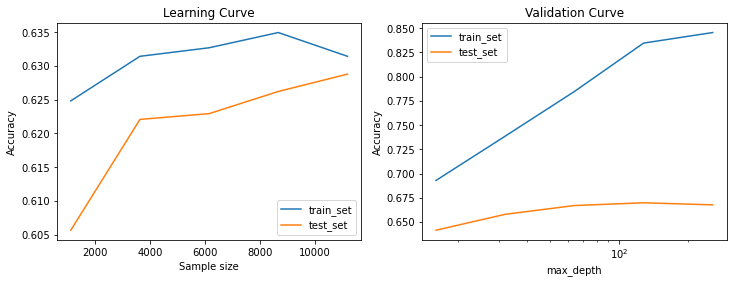

In [14]:
tree_depth = [16, 32, 64, 128, 256]
model_plots(xgb, 'max_depth', tree_depth)

In [88]:
xgb = XGBClassifier(n_estimators=100, 
                    learning_rate=0.001,
                    max_depth=128,
                    n_jobs=-1,
                    eval_set=ps, 
                    early_stopping_rounds=[5])

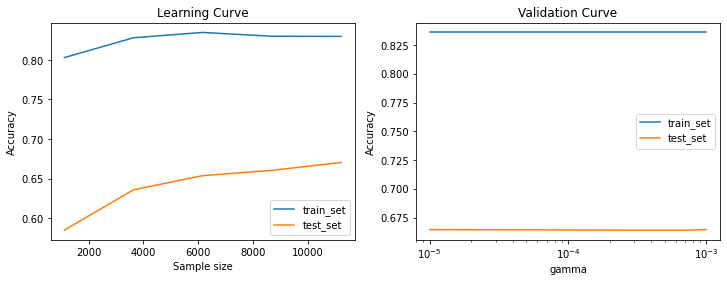

In [89]:
info_gain = np.linspace(10**-5, 10**-3, 5)
model_plots(xgb, 'gamma', info_gain)

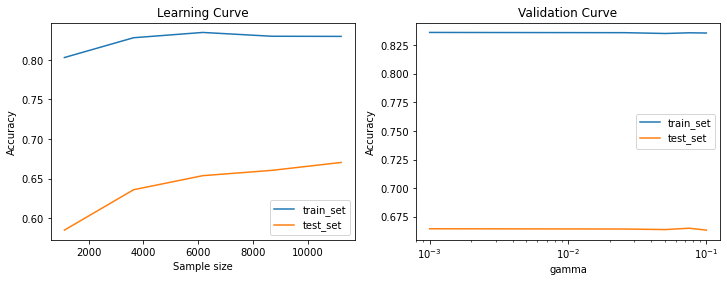

In [90]:
info_gain = np.linspace(10**-3, 10**-1, 5)
model_plots(xgb, 'gamma', info_gain)

### Light boost 

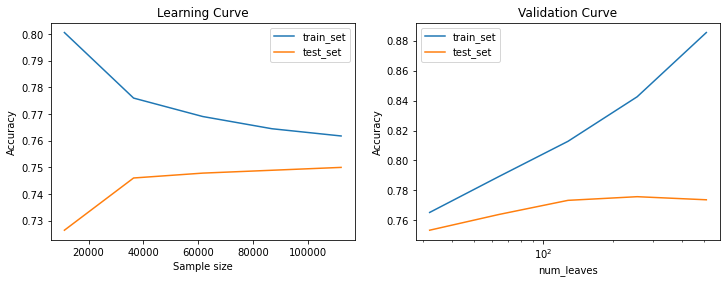

In [12]:
lgbm = LGBMClassifier()

n_leaf = [32, 64, 128, 256, 512]
model_plots(lgbm, 'num_leaves', n_leaf)

### Grid search approach 

In [20]:
parameters = {'alpha':[0.05, 0.1, 0.5, 1, 5, 10, 50]}

vector = TfidfVectorizer()
nb = BernoulliNB()

clf = GridSearchCV(nb, parameters, 
                  cv=ps, refit=True, 
                  n_jobs=-1)

nb_pipeline = Pipeline(steps=[('vec', vector),('clf', clf)])

nb_pipeline.fit(X_trainvalid, y_trainvalid)
nb_pipeline.score(X_test, y_test)

0.7535

In [25]:
n_words = [5000]
n_trees = [100]
l_rate = [0.001]

parameters = {'max_features':n_words, 
              'n_estimators':n_trees, 
              'learning_rate':l_rate}

vector = TfidfVectorizer()
xgb = XGBClassifier(eval_set=[X_valid, y_valid], 
                   early_stopping_rounds=[10])

clf = GridSearchCV(xgb, parameters, 
                  cv=ps, refit=True, 
                  n_jobs=-1)

xgb_pipeline = Pipeline(steps=[('vec', vector),('clf', clf)])

xgb_pipeline.fit(X_trainvalid, y_trainvalid)
xgb_pipeline.score(X_test, y_test)

0.6285

# Fine tuned models 

Make a function to calculate all the predictions 

In [ ]:
nb = BernoulliNB(alpha=1)
lr = LogisticRegression(solver='saga', C=0.5)
svc = SVC(C=0.5)

rf = RandomForestClassifier(n_estimators=100, 
                            max_depth=200,
                            max_features='sqrt',
                            min_impurity_decrease=0.0001,
                            n_jobs=-1)


xgb = XGBClassifier(n_estimators=100, 
                    learning_rate=0.001,
                    gamma=0.1,
                    max_depth=200,
                    n_jobs=-1,
                    eval_set=ps, 
                    early_stopping_rounds=[5])

lgb = LGBMClassifier(num_leaves=300)

cbc = CatBoostClassifier(verbose=False, 
                         task_type = 'GPU',
                         num_trees=100)

In [17]:
def model_pipeline(model):
    
    vector = TfidfVectorizer()
    pipeline = Pipeline(steps=[('vec', vector),('clf', model)])
    return pipeline 

In [18]:
lr_pipeline = model_pipeline(lr)

lr_pipeline.fit(X_trainvalid, y_trainvalid)
lr_pipeline.score(X_test, y_test)

0.7813022294281177

In [30]:
nb_pipeline = model_pipeline(nb)

nb_pipeline.fit(X_trainvalid, y_trainvalid)
nb_pipeline.score(X_test, y_test)

0.7674917787493696

In [ ]:
svc_pipeline = model_pipeline(svc)

svc_pipeline.fit(X_trainvalid, y_trainvalid)
svc_pipeline.score(X_test, y_test)

In [ ]:
rf_pipeline = model_pipeline(rf)

rf_pipeline.fit(X_trainvalid, y_trainvalid)
rf_pipeline.score(X_test, y_test)

In [ ]:
xgb_pipeline = model_pipeline(xgb)

xgb_pipeline.fit(X_trainvalid, y_trainvalid)
xgb_pipeline.score(X_test, y_test)

In [ ]:
lgb_pipeline = model_pipeline(lgb)

lgb_pipeline.fit(X_trainvalid, y_trainvalid)
lgb_pipeline.score(X_test, y_test)

In [ ]:
cbc_pipeline = model_pipeline(cbc)

cbc_pipeline.fit(X_trainvalid, y_trainvalid)
cbc_pipeline.score(X_test, y_test)

In [ ]:
joblib.dump(lr_pipeline, 'lr_pipeline.pkl') 
joblib.dump(nb_pipeline, 'nb_pipeline.pkl') 
joblib.dump(svc_pipeline, 'svc_pipeline.pkl') 
joblib.dump(rf_pipeline, 'rf_pipeline.pkl') 
joblib.dump(xgb_pipeline, 'xgb_pipeline.pkl') 
joblib.dump(lgb_pipeline, 'lgb_pipeline.pkl') 
joblib.dump(cbc_pipeline, 'cbc_pipeline.pkl') 